In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor())

# Data loader
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


c:\Users\MILab\.conda\envs\hr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 2)  # 2-dimensional bottleneck
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Output a value between 0 and 1
        )

    def forward(self, x):
        feature = self.encoder(x)
        x = self.decoder(feature)
        return feature, x

model = Autoencoder().to(device)

In [3]:
class Softmax_regression(nn.Module):
    def __init__(self):
        super(Softmax_regression, self).__init__()
        self.layer = nn.Linear(2,10)
    def forward(self, x):
        x = self.layer(x)
        return x
classifier = Softmax_regression().to(device)

In [5]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.reshape(-1, 28*28).to(device)
        # Forward pass
        _ , output = model(img)
        # for AE
        loss = criterion(output, img)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'[AE] Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

[AE] Epoch [1/15], Loss: 0.0587
[AE] Epoch [2/15], Loss: 0.0535
[AE] Epoch [3/15], Loss: 0.0536
[AE] Epoch [4/15], Loss: 0.0486
[AE] Epoch [5/15], Loss: 0.0496
[AE] Epoch [6/15], Loss: 0.0476
[AE] Epoch [7/15], Loss: 0.0445
[AE] Epoch [8/15], Loss: 0.0424
[AE] Epoch [9/15], Loss: 0.0437
[AE] Epoch [10/15], Loss: 0.0435
[AE] Epoch [11/15], Loss: 0.0452
[AE] Epoch [12/15], Loss: 0.0411
[AE] Epoch [13/15], Loss: 0.0429
[AE] Epoch [14/15], Loss: 0.0435
[AE] Epoch [15/15], Loss: 0.0446


In [7]:
# Loss and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(classifier.parameters(), lr=1e-3)
# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    for data in train_loader:
        img, target = data
        img = img.reshape(-1, 28*28).to(device)
        target = target.to(device)
        # Forward pass
        features, output = model(img)
        digits = classifier(features)
        # for AE
        loss = criterion(output, img)
        # for Classifier
        loss2 = criterion2(digits, target)
        # Backward and optimize
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
    print(f'[classifier] Epoch [{epoch+1}/{num_epochs}], Loss: {loss2.item():.4f}')

[classifier] Epoch [1/15], Loss: 2.4544
[classifier] Epoch [2/15], Loss: 1.7839
[classifier] Epoch [3/15], Loss: 1.6698
[classifier] Epoch [4/15], Loss: 1.5073
[classifier] Epoch [5/15], Loss: 1.4884
[classifier] Epoch [6/15], Loss: 1.4788
[classifier] Epoch [7/15], Loss: 1.5480
[classifier] Epoch [8/15], Loss: 1.3653
[classifier] Epoch [9/15], Loss: 1.4267
[classifier] Epoch [10/15], Loss: 1.4474
[classifier] Epoch [11/15], Loss: 1.6212
[classifier] Epoch [12/15], Loss: 1.4216
[classifier] Epoch [13/15], Loss: 1.5538
[classifier] Epoch [14/15], Loss: 1.6986
[classifier] Epoch [15/15], Loss: 1.5705


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        features, output = model(images)
        digits = classifier(features)
        _, predicted = torch.max(digits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy =100 * correct / total

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        features, output = model(images)
        digits = classifier(features)
        _, predicted = torch.max(digits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy =100 * correct / total


print(f'Accuracy on the training set: {train_accuracy}%')
print(f'Accuracy on the testing set: {test_accuracy}%')

Accuracy on the training set: 51.03333333333333%
Accuracy on the testing set: 51.08714285714286%


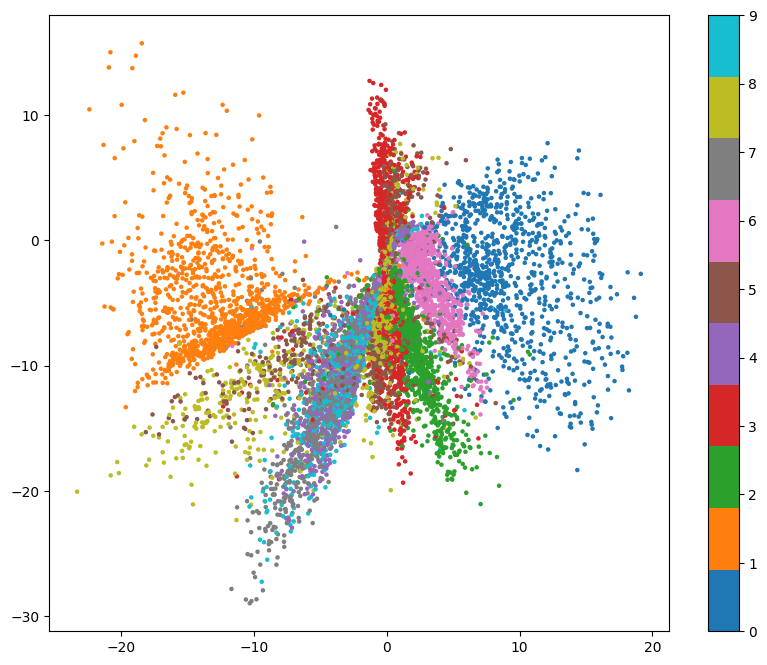

In [6]:
# Testing and plotting the encoded data
model.eval()
with torch.no_grad():
    plt.figure(figsize=(10, 8))
    for data in test_loader:
        img, labels = data
        img = img.reshape(-1, 28*28).to(device)
        encoded_imgs = model.encoder(img).cpu().numpy()
        plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.show()

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.reduction = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )# Penultimate layer with 2 neurons
        self.output= nn.Linear(2, 10)   # Output layer with 10 neurons for classification
        

    def forward(self, x):
        # We extract the features from the penultimate layer as well as the output
        feature = self.reduction(x)
        output = self.output(feature)
        return output, feature

model = MLP().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    for data in train_loader:
        img, labels = data
        img = img.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        # Forward pass
        outputs, _ = model(img)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/15], Loss: 0.8319
Epoch [2/15], Loss: 0.7003
Epoch [3/15], Loss: 0.5111
Epoch [4/15], Loss: 0.3810
Epoch [5/15], Loss: 0.5548
Epoch [6/15], Loss: 0.2525
Epoch [7/15], Loss: 0.2909
Epoch [8/15], Loss: 0.1795
Epoch [9/15], Loss: 0.2585
Epoch [10/15], Loss: 0.1847
Epoch [11/15], Loss: 0.1832
Epoch [12/15], Loss: 0.1585
Epoch [13/15], Loss: 0.1888
Epoch [14/15], Loss: 0.1241
Epoch [15/15], Loss: 0.1889


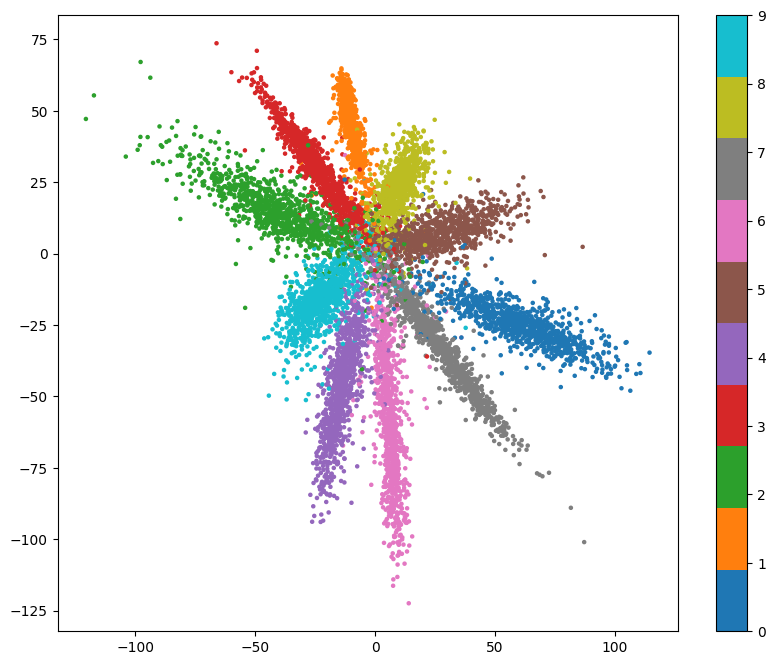

In [18]:
# Testing and plotting the encoded data
model.eval()
features = []
labels_list = []

with torch.no_grad():
    plt.figure(figsize=(10, 8))
    for data in test_loader:
        img, labels = data
        img = img.reshape(-1, 28*28).to(device)
        _, encoded_imgs = model(img)
        features.append(encoded_imgs.cpu().numpy())
        labels_list.append(labels.numpy())

    features = np.concatenate(features)
    labels_list = np.concatenate(labels_list)
    plt.scatter(features[:, 0], features[:, 1], c=labels_list, cmap='tab10', s=5)
    plt.colorbar()
    plt.show()


In [19]:
def calculate_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

train_accuracy = calculate_accuracy(train_loader)
test_accuracy = calculate_accuracy(test_loader)

print(f'Accuracy on the training set: {train_accuracy}%')
print(f'Accuracy on the testing set: {test_accuracy}%')


Accuracy on the training set: 96.405%
Accuracy on the testing set: 93.08%
